In [0]:
import numpy as np
import math
from scipy.optimize import minimize  
import time

# Oracle Complexity Separation

##### Katyusha
https://arxiv.org/pdf/1603.05953.pdf

In [0]:
def orac_psi_kat(x, ksik, ksi0, p_grad_h, L, Lh):
    nor1 = np.linalg.norm(x - ksik, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - ksi0, 2)
    nor_sq2 = nor2*nor2
    
    return float(np.dot(p_grad_h(ksik).T, x - ksik)) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2

In [0]:
def orac_z(x, alpha, p_orac_psi_kat, zk, gr_tilde, ksik, ksi0, p_grad_h, L, Lh):
    
    nor1 = np.linalg.norm(x - zk, 2)
    nor_sq1 = nor1*nor1

    return 1 / 2 / alpha * nor_sq1  + float(np.dot(gr_tilde.T, x)) + p_orac_psi_kat(x, ksik, ksi0, p_grad_h, L, Lh)

In [0]:
def argmin_sol(x, alpha, p_orac_psi_kat, zk, gr_tilde, ksik, ksi0, p_grad_h, L, Lh):
   return (1 / alpha * zk - gr_tilde + Lh * ksik + L * ksi0 - p_grad_h(ksik)) / (1 / alpha + Lh + L)

In [0]:
def Katyusha(x0, S_n, L, p_grad_h, p_grad_g, p_stoch_grad, p_orac_z, eps, p_h, Lh, ksik, ksi0, p_orac_psi_kat):
    n_dim = x0.shape[0]
    n_sam = n_dim - 1
    m = 1 # 2 * n_sam
    tau2 = 0.5
    n = n_sam
 
    y = np.copy(x0)
    z = np.copy(x0)
    x_tilde = np.copy(x0)
    
    num_grad_g_stoch_calls = 0
    
    for i in range(0, S_n):
        grad_mu = p_grad_g(x_tilde)
        num_grad_g_stoch_calls = num_grad_g_stoch_calls + n_sam
        tau1 = 2 / (i + 4)
        
        alpha = 1 / 3 / tau1 / L
        
        sum_y = 0
        
        for j in range(0, m):
            k = s * m + j
            x = tau1 * z + tau2 * x_tilde + (1 - tau1 - tau2) * y
            a = np.random.randint(0, n_sam) 
            grad_x = p_stoch_grad(x, a)
            grad_x_tilde = p_stoch_grad(x_tilde, a)
            num_grad_g_stoch_calls = num_grad_g_stoch_calls + 2
            
            grad_t = grad_mu + grad_x - grad_x_tilde
            z_new = np.copy(z)
            
            
            # allargs = (alpha, p_orac_psi_kat, z, grad_t, ksik, ksi0, p_grad_h, L, Lh)
            # minim_res = minimize(p_orac_z, args = allargs, x0 = np.ravel(z), tol = eps, options={'maxiter': 15, 'disp': False})

            minim_res2 = argmin_sol(z_new, alpha, p_orac_psi_kat, z, grad_t, ksik, ksi0, p_grad_h, L, Lh)
            
            # print("Norm", np.linalg.norm(minim_res.x - minim_res2))

            #print('j inside Kat', j)
            z_new = minim_res2
            y = x + tau1 * (z_new - z)
            z = z_new
            
            sum_y = sum_y + y
        x_tilde = 1 / m * sum_y    
    return x_tilde, num_grad_g_stoch_calls

##### Gradient Method for Composite Optimization
 

$\phi_{i}(y) := \langle \nabla h(y^{k}), \, y - y^{k} \rangle + g(y) + \tfrac{L_h}{2} \|y - y^{k}\|_2^2 + \tfrac{L}{2} \|y - y^{0}\|_2^2$

In [0]:
# Psi function
# Input parameters:
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# yk --- y^{k}
# L_h  --- Lipchitz for h(x)

def orac_psi(x, p_grad_h, p_g, Lh, yk, L, y0):
    
    nor1 = np.linalg.norm(x - yk, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - y0, 2)
    nor_sq2 = nor2*nor2
    
    return float(np.dot(p_grad_h(yk).T, x - yk)) + p_g(x) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2


# Gradient Method for Composite Optimization
# Input parameters:
# p_orac_psi --- oracle for Minimization Alg
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# y0 --- y^0 (first initial point for minimize)
# L_h  --- Lipchitz for h(x)
# N --- number of iterations
# xk1 --- $x^{k+1}$

def GradComposite(p_orac_psi, p_grad_h, p_g, Lh, y0, N, L, xk1, p_grad_g, eps, p_stoch_grad, p_h, p_orac_psi_kat):
    
    yi = np.copy(xk1)
    
    # nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi), 2)
    # nor2_krit = 0
    
    i = 0
    
    sum_calls = 0 

    # if nor1_krit <= L / 2 * nor2_krit:
     # return yi, sum_calls
    
    # while True: 
    while True:
        
        i = i + 1
        
        allargs = (p_grad_h, p_g, Lh, yi, L, y0)
        
        #print('minimize start', yi.shape, y0.shape)
        yi, calls = Katyusha(yi, 1, L, p_grad_h, p_grad_g, p_stoch_grad, orac_z, eps, p_h, Lh, yi, y0, p_orac_psi_kat)
        sum_calls = sum_calls + calls
        
        # nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi) + L*(yi - y0), 2)
        # nor2_krit = np.linalg.norm(yi - y0, 2)
        #print('Comp', i, nor1_krit)  
       
        # if nor1_krit <= L / 2 * nor2_krit:
          #  print("BREAK")
           # break
        
        if i > 0:
          break
    
    return yi, sum_calls

#### Monteiro–Svaiter Accelerated Proximal method
Parameters:  
$L > 0$    
$x0$ --- initial point  
$N$ --- number of iterations  
$type\_z\_step$ --- 1 -- stardard version for calculating $z$, 2 -- experimental version for calculating $z$ (without gradient of $f(x)$)   

In [0]:
def ms_acc_prox_method(L, Lh, x0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, eps, p_stoch_grad, p_h, verbose = 0, time_scale = False):

    # Initial points
    y0 = np.copy(x0)
    z0 = np.copy(x0)

    it = 0

    x = x0
    y = y0
    z = z0

    plt1 = []
    
    Ak = 0
    
    times = []
    
    time_start = time.time()
    
    calls = []
    
    while  it < N: 
        it = it + 1
        
        ak = (1/L + math.sqrt(1/L/L + 4 * Ak / L)) / 2
        Ak1 = Ak + ak
        
        x = Ak / Ak1 * y + ak / Ak1 * z
        
        #print('mm', x.shape, y.shape, z.shape)
        y, co = GradComposite(orac_psi, p_grad_h, p_g, Lh, x, N, L, x, p_grad_g, eps, p_stoch_grad, p_h, orac_psi_kat)
                
        if type_z_step == 1:
            z = z - ak * (p_grad_h(y) + p_grad_g(y))
        elif type_z_step == 2:    
            z = z - ak * L * (x - y)
        
        if verbose == 1:
            print("x y z ak Ak Ak+1", x.shape, y.shape, z.shape, ak, Ak, Ak1)
        
        Ak = Ak1
     

        time_end = time.time() - time_start
        if time_scale:
            times.append(time_end)
            
        if verbose == 1:
            print('Main loop: iter f(y)')
        
        fy = p_f(y)
        plt1.append(fy)
        
        calls.append(co)
        
        if verbose == 1:
            print(it, fy)
        
    return N, y, plt1, times, calls

##### Restarts for MS

In [0]:
def ms_restarts(mu, L, Lh, eta0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, verbose = 0):
    
    N1, y1, plt1 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 1, verbose = 1)
    

In [10]:
import pandas as pd
from google.colab import files
import io

uploaded2 = files.upload()

# Load data from a csv file
bcdf = pd.read_csv(io.BytesIO(uploaded2['breast-cancer-wisconsin.data']), header = None)

Saving breast-cancer-wisconsin.data to breast-cancer-wisconsin.data


#### Case 1. Kernel SVM

In [11]:
import pandas as pd
# Load data from a csv file
bcdf = pd.read_csv('breast-cancer-wisconsin.data', header = None)

# Drop unecessary columns
bcdf.drop([0], axis = 1, inplace = True)

print(bcdf.size)
bcdf.replace('?', np.nan, inplace = True)
bcdf.dropna(inplace = True)
print(bcdf.size)

bcdf[10].replace(2, 1, inplace = True)
bcdf[10].replace(4, -1, inplace = True)

bcdf = bcdf.apply(pd.to_numeric, errors = 'ignore')
bcdf.info()

6990
6830
<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       683 non-null    int64
 1   2       683 non-null    int64
 2   3       683 non-null    int64
 3   4       683 non-null    int64
 4   5       683 non-null    int64
 5   6       683 non-null    int64
 6   7       683 non-null    int64
 7   8       683 non-null    int64
 8   9       683 non-null    int64
 9   10      683 non-null    int64
dtypes: int64(10)
memory usage: 58.7 KB


In [12]:
bcdf.groupby(10).mean()

,1,2,3,4,5,6,7,8,9
10,,,,,,,,,
-1,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510
1,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315


In [76]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split data into testing and training set. Use 67% for training
X_train, X_test, y_train, y_test = train_test_split(bcdf.iloc[:,:-1], bcdf[10], train_size = .67)

# Instantiate 
norm = Normalizer()

# Fit
norm.fit(X_train)

# Transform both training and testing sets
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}

kfold = KFold(n_splits = 5, shuffle = True)#, random_state = 42)

model_grid = GridSearchCV(SVC(), SVM_params)

cv_results = cross_val_score(model_grid, X_train_norm, y_train, cv = kfold, scoring = 'accuracy')

msg = "Cross Validation Accuracy %s: Accuracy: %f SD: %f" % ('SVM sklearn', cv_results.mean(), cv_results.std())

print(msg)

Cross Validation Accuracy SVM sklearn: Accuracy: 0.899355 SD: 0.033545


$$
\min_{\beta_0, \, \beta} \sum_{i = 1}^n [1 - y_i (\beta_0 + \beta x_i)]_+ + \frac{\lambda}{2} \| \beta \|_2
$$

$$
\min_{\beta_0, \, \theta} L[y, \, K \theta] + \frac{\lambda}{2} \theta^T K \theta
$$

$K$ is $n \times n$ matrix, $K(x, x') = \exp(-\gamma \|x - x' \|^2)$

In [14]:
pd.to_numeric(X_train[6])

430     1
307     1
537     1
143     5
568    10
       ..
156     1
159    10
306     1
376     1
369     1
Name: 6, Length: 457, dtype: int64

In [0]:
# Oracles

# h(x) is strongly convex

lam = 0.01
gamma = 1e10

n_sam = X_train.values.shape[0]
X_arr = X_train.values
y_arr = y_train.values.reshape(n_sam, 1)

def K_func(xi, xj):
    nor = np.linalg.norm(xi - xj, 2)
    return np.exp(-gamma * nor * nor)

K_matrix = np.zeros((n_sam, n_sam))
E_matrix = np.identity(n_sam)
for i in range(0, n_sam):
    for j in range(0, n_sam):
        K_matrix[i][j] = K_func(X_arr[i, :], X_arr[j, :])

def h1(btheta):
    theta = btheta[1:] 
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    #print('h1', lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta))))
    return lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta)))

def grad_h1(btheta):
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    gr = lam*np.dot(K_matrix, theta)
    #print('gr', gr.shape)
    gr0 = np.insert(gr, 0, 0)#, axis = 0)
    #print('gr h1', gr0.shape, np.linalg.norm(gr), gr[3], theta[3])
    return gr0 

def g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    beta0 = btheta[0]
    s2 = 0
    for i in range(0, n_dim):
                      
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        
        if ty <= 1 - mu_n:
            pos = 1 - ty - mu_n / 2
        elif ty <= 1:
            pos = (1 - ty) * (1 - ty) / 2 / mu_n
        else:
            pos = 0
        s2 = s2 + pos  
        
    return 1 / n_sam * float(s2)

def grad_g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = btheta[0]
    
    gr = np.zeros(btheta.shape)#.reshape(n_dim, 1)    
    sum_for_beta0 = 0
    sum_for_beta = 0
    for i in range(0, n_dim):
        #print(theta.T.shape, K_matrix[i, :].reshape(n_dim, 1).shape)
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        
        if ty <= 1 - mu_n:
            for_beta0 = float(-y_arr[i])
            for_beta = for_beta0*K_matrix[i, :]
            #print(ty, for_beta0.shape, for_beta.shape)
        elif ty <= 1:
            for_beta0 = 1 / mu_n * float((1 - ty) * (-y_arr[i]))
            for_beta = for_beta0 * K_matrix[i, :]
        else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
        
        sum_for_beta0 = sum_for_beta0 + for_beta0
        sum_for_beta = sum_for_beta + for_beta
        #print(i, ty, sum_for_beta0, sum_for_beta.shape, np.linalg.norm(sum_for_beta))
    #print(sum_for_beta0, np.linalg.norm(sum_for_beta))    
    gr[0] = sum_for_beta0
    gr[1:] = sum_for_beta
    
    return 1 / n_sam * gr
    
def f1(x):
    return h1(x) + g1(x)

def grad_f1(x):
    return grad_h1(x) + grad_g1(x)

def stoch_grad(x, a):
    
    theta = x[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = x[0]
    
    gr = np.zeros(x.shape)#.reshape(n_dim, 1)    
        
    ty = y_arr[a]*(beta0 + float(np.dot(theta.T, K_matrix[a, :].reshape(n_dim, 1))))
    ty = float(ty)
        
    if ty <= 1 - mu_n:
            for_beta0 = float(-y_arr[a])
            for_beta = for_beta0*K_matrix[a, :]
            #print(ty, for_beta0.shape, for_beta.shape)
    elif ty <= 1:
            for_beta0 = 1 / mu_n * float((1 - ty) * (-y_arr[a]))
            for_beta = for_beta0 * K_matrix[a, :]
    else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
        
    gr[0] = for_beta0
    gr[1:] = for_beta
    
    return 1 / n_sam * gr        

In [78]:
eps = 1e-1
mu_n = eps # Parameter for Nesterov's smoothing

def check_L(p_orac):
    L = 1e-20
    step = 2
    for i in range(int(1e4)):
        rn1 = np.random.randint(0, 1e8)
        
        x = -rn1 * np.random.rand(n_sam + 1)
        rn2 = np.random.randint(0, 1e2)
        y = rn2 * np.random.rand(n_sam + 1)
        #print(rn1, rn2, np.linalg.norm(x), np.linalg.norm(y))
        d1 = np.linalg.norm(p_orac(x) - p_orac(y))
        d2 = np.linalg.norm(x - y)
        #print(d1, d2)
        while d1 > L*d2:
                L = step*L
                #print(d1, d2, L)
        break        
    return L            
Lh = check_L(grad_h1)
Lg = check_L(grad_g1)

print('Lh exp ', Lh, 'Lg exp', Lg)

Lh exp  0.09223372036854775 Lg exp 2.74877906944e-09


In [79]:
n = 10
x0 = 10*np.random.rand(n_sam + 1)

import scipy
w, v = scipy.linalg.eig(K_matrix)
Lh = lam * (int(np.max(w)) + 1)

print("Lh = ", Lh)
L = 1
Lh = Lh

norm_x0 = np.linalg.norm(x0, 2)
s = sum([np.linalg.norm(X_arr[i], 2) for i in range(0, n_sam)])
norm_opt = min([1 / n_sam / lam*s, math.sqrt(2/lam)])
norm_x0

#T = math.log((norm_x0*norm_x0 + norm_opt*norm_opt + 2*norm_x0*norm_opt) * mu / eps)
#N0 = math.sqrt(8 * L / mu)
#N0

R2 = (norm_x0 - norm_opt)**2
T = math.sqrt(L   / eps)
print("T, R^2, L, Lh", T, R2, L, Lh)

Lh =  0.19
T, R^2, L, Lh 3.1622776601683795 12324.574694695268 1 0.19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [0]:
N_minn = math.log(1/eps)
N_minn

N = 100

In [86]:
N1 = N

N1, y1, plt1, times_MS, calls = ms_acc_prox_method(L, Lh, x0, N1, grad_h1, g1, grad_g1, f1, 1, eps, stoch_grad, h1, verbose = 0, time_scale = True)

print('Answer 1: ', N1, f1(y1))

Answer 1:  100 0.5809373422753135


In [0]:
def FGM(p_func, p_grad_func, x0, N=10, L=1, restart=None, return_losses=True, time_scale=False, verbose = 0, coord = 0):
    
    n_dim = x0.shape[0]
    n_sam = n_dim - 1
    
    x = x0.copy()
    v = x0.copy()
    
    A = 0
    S = L / 2
    
    losses = []
    times = []
    calls = []
    
    if coord == 1:
        time_start = time.time()
        
        for k in range(N):
            a = np.roots([S, -1, -A]).max()
            A = A + a
            alpha = a / A
        
            ir = np.random.randint(0, n_sam) 
        
            y = (1 - alpha) * x + alpha * v
        
            x[ir] = y[ir] - (1 / L) * p_grad_func(y)[ir]
            v[ir] = v[ir] - a * p_grad_func(x)[ir]
        
            time_end = time.time() - time_start
            if time_scale:
                times.append(time_end)
        
            fx = p_func(x)
            losses.append(fx)
        
            if verbose == 1:
                print(fx)
            
            calls.append(2)
                
    else:
        
        time_start = time.time()
    
        for k in range(N):
            a = np.roots([S, -1, -A]).max()
            A = A + a
            alpha = a / A
        
            y = (1 - alpha) * x + alpha * v
        
            x = y - (1 / L) * p_grad_func(y)
            v = v - a * p_grad_func(x)
        
            time_end = time.time() - time_start
            if time_scale:
                times.append(time_end)
        
            fx = p_func(x)
            losses.append(fx)
        
            if verbose == 1:
                print(fx)
            
            calls.append(n_sam*2)
        
    if return_losses and time_scale:
        return x, np.array(losses), np.array(times), calls
    elif return_losses:
        return x, np.array(losses)
    else:
        return x

In [0]:
Lf = max([L, Lh])
N2 = N
x, losses, times_FG, calls_FG = FGM(f1, grad_f1, x0, N=N2, L= Lf, restart=None, return_losses=True, time_scale = True, verbose = 0)

In [0]:
N3 = N
x, losses_c, times_FG_c, calls_FG_c = FGM(f1, grad_f1, x0, N=N3, L= L, restart=None, return_losses=True, time_scale = True, verbose = 0, coord = 1)

In [0]:
#losses, plt1

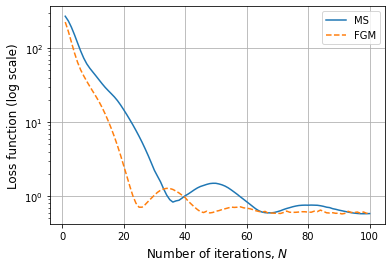

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, N1 + 1), plt1, label = 'MS', ls = '-')
plt.plot(range(1, N2 + 1), losses, label = 'FGM', ls = '--')
#plt.plot(range(1, N3 + 1), losses_c, label = 'FGM coord', ls = '-.')
plt.yscale('log')
plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Loss function (log scale)", fontsize=12)
plt.legend()
plt.show()

In [91]:
#print(times_FG)
#print(times_MS)
print(plt1[-1], losses[-1])

0.5809373422753135 0.5871666270177097


In [92]:
time_max = min(
    times_MS[-1] - times_MS[0],
    times_FG[-1] - times_FG[0]
)
ms_times_max_idx = np.searchsorted(np.array(times_MS) - times_MS[0], time_max, side="right")
fg_times_max_idx = np.searchsorted(np.array(times_FG) - times_FG[0], time_max, side="right")
print(time_max, ms_times_max_idx, fg_times_max_idx)

1.8644890785217285 100 97


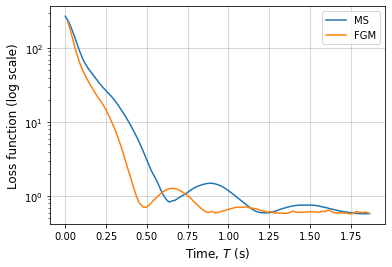

In [93]:
  %matplotlib inline
plt.semilogy((np.array(times_MS) - times_MS[0])[:ms_times_max_idx], (plt1)[:ms_times_max_idx], label="MS")
plt.semilogy(times_FG[:fg_times_max_idx], (losses)[:fg_times_max_idx], label="FGM")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Loss function (log scale)", fontsize=12)
plt.legend()
plt.show()


In [94]:
#print(calls, calls_FG)
n_calls = np.cumsum(calls)
n_calls_FG = np.cumsum(calls_FG)
print(n_calls, n_calls_FG)

[  459   918  1377  1836  2295  2754  3213  3672  4131  4590  5049  5508
  5967  6426  6885  7344  7803  8262  8721  9180  9639 10098 10557 11016
 11475 11934 12393 12852 13311 13770 14229 14688 15147 15606 16065 16524
 16983 17442 17901 18360 18819 19278 19737 20196 20655 21114 21573 22032
 22491 22950 23409 23868 24327 24786 25245 25704 26163 26622 27081 27540
 27999 28458 28917 29376 29835 30294 30753 31212 31671 32130 32589 33048
 33507 33966 34425 34884 35343 35802 36261 36720 37179 37638 38097 38556
 39015 39474 39933 40392 40851 41310 41769 42228 42687 43146 43605 44064
 44523 44982 45441 45900] [  914  1828  2742  3656  4570  5484  6398  7312  8226  9140 10054 10968
 11882 12796 13710 14624 15538 16452 17366 18280 19194 20108 21022 21936
 22850 23764 24678 25592 26506 27420 28334 29248 30162 31076 31990 32904
 33818 34732 35646 36560 37474 38388 39302 40216 41130 42044 42958 43872
 44786 45700 46614 47528 48442 49356 50270 51184 52098 53012 53926 54840
 55754 56668 57582 58496 

In [95]:
o_max = min(
    n_calls[-1],
    n_calls_FG[-1]
)
ms_idx = np.searchsorted(np.array(n_calls), o_max, side="right")
fg_idx = np.searchsorted(np.array(n_calls_FG), o_max, side="right")
print(o_max, ms_idx, fg_idx)

45900 100 50


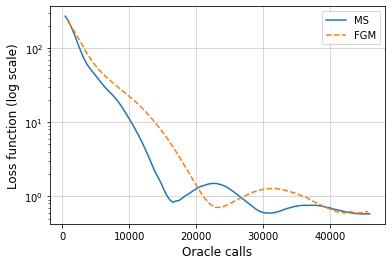

In [96]:
%matplotlib inline
plt.semilogy((np.array(n_calls))[:ms_idx], (plt1)[:ms_idx], label="MS", ls='-')
plt.semilogy(n_calls_FG[:fg_idx], (losses)[:fg_idx], label="FGM", ls = '--')

plt.grid(linewidth=0.5)

plt.xlabel(r"Oracle calls", fontsize=12)
plt.ylabel(r"Loss function (log scale)", fontsize=12)
plt.legend()
plt.show()
